In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import matplotlib.colors as colors

In [9]:
hbar = 1.055e-34 # (J / Hz) = (kg * m^2 / s)
c = 299792458    # m / s
pi = np.pi

Most of the formulae can be found in these papers:
* https://arxiv.org/pdf/1907.12838.pdf
* https://arxiv.org/pdf/2012.15188.pdf, Appendix A2
* https://arxiv.org/pdf/1603.03420.pdf
* https://arxiv.org/pdf/1708.06628.pdf

We will follow the convention in which the variance of a stochastic quantity $y$ is
$$
    \langle y^2 \rangle = \int^{\infty}_{\infty} \frac{d \omega}{2 \pi} S_{yy} (\omega) = \int^{\infty}_{0} \frac{d \omega}{2 \pi} S_{y} (\omega)
$$
where $S_{yy} (\omega)$ is the double-sided power spectrum and $S_{y} (\omega)$ is the single-sided one. In general the Novotny group papers use a different convention.

Realistic experimental parameters mostly follow here
https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.116.243601/supplementary05.pdf

Focusing on the y-axis motion, we assume a ~100 nm particle with resonant freuqency 150 kHz, with some total damping measured in the experiment.

In [10]:
lam = 1064e-9                  # Laser wavelength (m)
k = 2 * np.pi / lam
p_sca = 3.53e-6                # Scattered laser power (W)
m = 1.14e-18                   # Particle mass (kg)
Omega_0 = 2 * pi * 150 * 1000  # Resonant frequency (Hz)
gamma = 2 * pi * 269.9         # Damping (Hz)

Oscillator parameters (zero-point fluctuations and susceptibility)
$$
    y_{\mathrm{zpf}} = \sqrt{\frac{\hbar}{2 m \Omega_y}}, \\
    \chi(\omega) = \frac{1}{m} \cdot \frac{1}{\Omega_y - \omega^2 - i \gamma \omega}
$$

In [11]:
# Make an array of freuqencies
omega = np.linspace(0, 2*300e3*np.pi, 10000)

In [12]:
zpf = np.sqrt(hbar / (2 * m * Omega_0))                      # Zero point fluctuation (m)
chi = (1 / m) / (Omega_0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility

Double-sided power spectral densities (assume an x-polarized beam and perfect photon collection). Our double-sided power spectra would differ from the Novotny group paper by a factor of $2 \pi$.
$$
    S^{\mathrm{imp}}_{yy}(\omega) = \frac{5}{2} \frac{\hbar c}{4k} \frac{1}{P_{\mathrm{sca}}(\omega)}, \\
    S^{\mathrm{bac}}_{FF}(\omega) = \frac{2}{5} \frac{\hbar k}{c} P_{\mathrm{scat}}(\omega).
$$
Here $P_{\mathrm{scat}}(\omega) = P_{\mathrm{scat}}$ is the total scattered power and we can just assume it's frequency independent here.

In [13]:
S_yy_imp = (5/2) * (hbar * c / (4 * k)) / p_sca  # Imprecision
S_ff_y_ba = (2/5) * (hbar * k / c) * p_sca       # Backaction force spectrum

Convert to single-sided spectral densities. Also we introduce zero-point fluctuations as
$$
    S^{\mathrm{zpf}}_y (\omega) = y^2_{\mathrm{zpf}} \cdot \frac{\gamma}{(\omega-\Omega_y)^2 + (\gamma / 2)^2}
$$
The total (single-sided) displacement noise is then
$$
    S^{\mathrm{tot}}_y (\omega) = S^{\mathrm{imp}}_{y}(\omega) + S^{\mathrm{bac}}_{F}(\omega) |\chi(\omega)|^2 + 
    S^{\mathrm{zpf}}_y (\omega).
$$

In [14]:
S_y_imp = 2 * S_yy_imp
S_f_y_ba = 2 * S_ff_y_ba
S_y_zpf = zpf**2 * gamma / ( (omega-Omega_0)**2 + (gamma/2)**2 )

S_y_tot = np.full_like(omega, S_y_imp) + S_f_y_ba * np.abs(chi) * np.abs(chi) + S_y_zpf

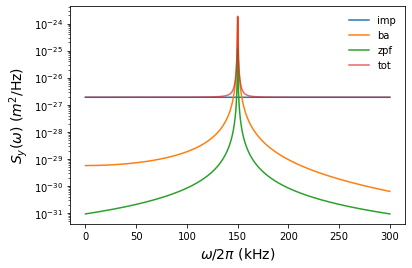

In [15]:
plt.plot(omega/(1000*2*pi), np.full_like(omega, S_y_imp), label='imp')
plt.plot(omega/(1000*2*pi), S_f_y_ba * np.abs(chi) * np.abs(chi), label='ba')
plt.plot(omega/(1000*2*pi), S_y_zpf, label='zpf')
plt.plot(omega/(1000*2*pi), S_y_tot, label='tot', alpha=0.7)

plt.yscale('log')
plt.xlabel(r'$\omega / 2 \pi$ (kHz)', fontsize=14)
plt.ylabel(r'$S_y(\omega)$ ($m^2$/Hz)', fontsize=14)
plt.legend(frameon=False)
plt.show()

On-resonance displacement noise contribution as a function of scattered laser power. I tried to reproduce Figure S1. in the paper above, but it seems like their imprecision noise is slightly different from what we have here.

In [16]:
plist = np.logspace(-8, -5, 1000)
stot = np.zeros((plist.size, 2))

In [17]:
for i, p in enumerate(plist):
    stot[i][0] = 2 * (5/2) * (hbar * c / (4 * k)) / p  # Imprecision
    stot[i][1] = 2 * (2/5) * (hbar * k / c) * p        # Backaction force spectrum

In [18]:
# Evaluated on resonance
S_y_zpf_0 = zpf**2 * gamma / ( (gamma/2)**2 )
chi_0 = (1 / m) / (-1 * gamma * Omega_0 * 1j) # Complex susceptibility

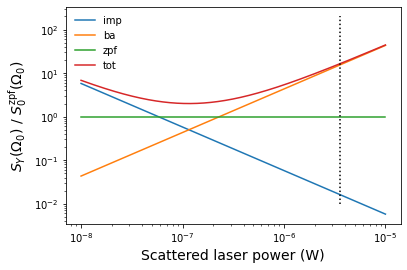

In [19]:
eta = 1
tot = (1/eta)*stot.T[0] +  stot.T[1] * np.abs(chi_0) * np.abs(chi_0) +S_y_zpf_0

plt.plot(plist, (1/eta)*stot.T[0] / S_y_zpf_0, label='imp')
plt.plot(plist, stot.T[1] * np.abs(chi_0) * np.abs(chi_0) / S_y_zpf_0, label='ba')
plt.plot(plist, np.ones_like(plist), label='zpf')
plt.plot(plist, tot / S_y_zpf_0, label='tot')
plt.vlines(p_sca, 1e-2, 200, linestyles='dotted', colors='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scattered laser power (W)', fontsize=14)
plt.ylabel(r'$S_{Y}(\Omega_0)$ / $S^{\mathrm{zpf}}_0(\Omega_0)}$', fontsize=14)
plt.legend(frameon=False)

Calculate the ideal momentum sensitivity. Following https://arxiv.org/pdf/cond-mat/0406536.pdf, we define the signal-to-noise ratio for an impulse force $F(t) = \Delta p \cdot \delta(t)$ as
$$
    S/N = (\Delta p)^2 \int \frac{d \omega}{2 \pi} \frac{|\lambda(\omega) \chi(\omega)|^2}{S_{I, \mathrm{tot}}(\omega)},
$$
where $\lambda(\omega)$ is the detector gain (power amplification) and $S_{I, \mathrm{tot}}(\omega)$ is the total measurement noise in the detector. In our case, we assume a perfect homodyne detection and the detected power simply scale linearly with the position of the particle. In other words, $\lambda(\omega)$ is simply a constant and drop out of the expression.

Assume that the minimum detected momentum transfer has $S/N=1$, we have
$$
    1 = S/N = (\Delta p_{\mathrm{min}})^2 \int \frac{d \omega}{2 \pi} \frac{|\chi(\omega)|^2}{S_{y, \mathrm{tot}}(\omega)},
$$
the expression
$$
    \int \frac{d \omega}{2 \pi} \frac{|\chi(\omega)|^2}{S_{y, \mathrm{tot}}(\omega)}
$$
is just the inverse of total force noise in the $y$ direction.

*Note added 05/05/2023:* 
One needs to be careful when dealing with one-sided power specta! A factor of $1/2$ is added in calculating $\Delta p$ to account for contribution from both the positive and negative freuqencies of the delta function.

By changing the frequency range of integration, one finds that most of the sensitivity is from the on-resonance detection.

In [20]:
integrand = (1 / (2*pi)) * np.abs(chi) * np.abs(chi) / (S_y_tot)
delta_p = 0.5 * np.sqrt(1 / np.trapz(integrand, omega))

SI2ev = (1 / 1.6e-19) * c
print('The minimum measurable impulse:', delta_p * SI2ev / 1000, 'keV')
print('The SQL is', np.sqrt(hbar * m * Omega_0) * SI2ev / 1000, 'keV')

The minimum measurable impulse: 20.306230537679518 keV
The SQL is 19.948715629107138 keV


Calculate momentum sensitivity as a function of damping. This answers one of my long-standing questions -- in general the sensitivity get worse when we increase damping, but in a quite nonlinear way.

Radiation force in the $y$ direction is given in https://arxiv.org/pdf/1708.06628.pdf , and one finds the radiation damping rate by dividing it by the paticle mass:
$$
    \gamma_{\mathrm{rad}} = \frac{4}{5} \frac{P_{\mathrm{sca}}}{m c^2}.
$$

In [21]:
# Radiation (backaction) damping in the y-direction
# From Eq. (22) of this paper: https://arxiv.org/pdf/1708.06628.pdf
gamma_rad = (4/5) * p_sca / (m * c**2)

In [22]:
def calc_momentum_sensitivity(p_sca, gamma):
    omega = np.linspace(0, 2*300e3*np.pi, 10000)
    
    zpf = np.sqrt(hbar / (2 * m * Omega_0)) # Zero point fluctuation (m)
    chi = (1 / m) / (Omega_0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility
    
    S_yy_imp = (5/2) * (hbar * c / (4 * k)) / p_sca  # Imprecision
    S_ff_y_ba = (2/5) * (hbar * k / c) * p_sca       # Backaction force spectrum
    
    # One-sided spectra
    S_y_imp = 2 * S_yy_imp
    S_f_y_ba = 2 * S_ff_y_ba
    S_y_zpf = zpf**2 * gamma / ( (omega-Omega_0)**2 + (gamma/2)**2 )
    S_y_tot = np.full_like(omega, S_y_imp) + S_f_y_ba * np.abs(chi) * np.abs(chi) + S_y_zpf
    
    integrand = (1 / (2*pi)) * np.abs(chi) * np.abs(chi) / S_y_tot
    delta_p = 0.5 * np.sqrt(1 / np.trapz(integrand, omega))
    
    return delta_p * SI2ev / 1000

This plots the total momentum sensitivity as a function of damping in the unit of radiaton damping, assuming a fixed scattered power. The dashed line is the measured damping value from the Novotny group paper.

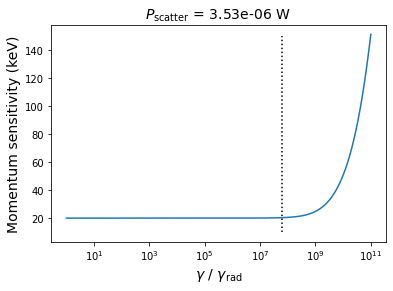

In [23]:
glist = np.logspace(np.log10(gamma_rad), np.log10(1e11*gamma_rad), 1000)
dplist = np.empty_like(glist)

for i, g in enumerate(glist):
    dplist[i] = calc_momentum_sensitivity(p_sca, g)
    
plt.plot(glist/gamma_rad, dplist)
plt.vlines(gamma/gamma_rad, 10, 150, linestyles='dotted', colors='k')
plt.xscale('log')
plt.title(r'$P_\mathrm{scatter}$ = '+f'{p_sca}'+' W', fontsize=14)
plt.xlabel(r'$\gamma$ / $\gamma_{\mathrm{rad}}$', fontsize=14)
plt.ylabel('Momentum sensitivity (keV)', fontsize=14)
plt.show()

Plot momentum sensitivity as a fuction of scattered power, assuming only radiation damping (in reality we need to add the feedback damping and everything). $P_{\mathrm{scatter}, 0}$ is the measured value in the Novotny group paper.

There should be a minimum value at which the particle can remain trapped, that value of which I'm not sure at this point. This calculation also does not take into account the shift of trap depth and resonant frequency while the power is changing. However, it does seem like we can comfortable get to a decent momentum sensitivity with a wide range of power.

In [24]:
plist = np.logspace(np.log10(p_sca*0.0001), np.log(2*p_sca*10000), 1000)
dplist2 = np.empty_like(plist)

for i, p in enumerate(plist):
    gamma_rad = (4/5) * p / (m * c**2)
    dplist2[i] = calc_momentum_sensitivity(p, gamma_rad)

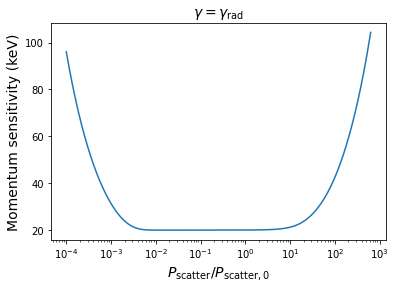

In [25]:
plt.plot(plist/p_sca, dplist2)

plt.xscale('log')
plt.title(r'$\gamma = \gamma_{\mathrm{rad}}$', fontsize=14)
plt.xlabel(r'$P_{\mathrm{scatter}} / P_{\mathrm{scatter}, 0}$', fontsize=14)
plt.ylabel('Momentum sensitivity (keV)', fontsize=14)
plt.show()

In [26]:
print(f'Best momentum sensitivity = {min(dplist2):.3f} keV')
print(f'The SQL is {np.sqrt(hbar * m * Omega_0) * SI2ev / 1000:.3f} keV')

Best momentum sensitivity = 19.949 keV
The SQL is 19.949 keV


## Information radiation density

The above imprecision noise assume perfect photon collection. We can calculate the information density following https://arxiv.org/pdf/1907.12838.pdf .

In [27]:
theta = np.linspace(0, pi, 1000)
phi = np.linspace(0, 2*pi, 1000)
tt, pp = np.meshgrid(theta, phi)

In [28]:
dp = (3/ (8*pi)) * p_sca * ( 1 - (np.sin(tt)**2) * (np.cos(pp)**2) ) * np.sin(tt)

The differential imprecision noise at each axis (these are double-sided spectra, and again we differ from them with a factor of $2 \pi$):
$$
    s^{\mathrm{imp}}_{xx} (\theta, \phi) = \frac{\hbar c}{4 k \sin^2{\theta} \cos^2{\theta} \cdot dp_{\mathrm{sca}}},\\
    s^{\mathrm{imp}}_{yy} (\theta, \phi) = \frac{\hbar c}{4 k \sin^2{\theta} \sin^2{\theta} \cdot dp_{\mathrm{sca}}},\\
    s^{\mathrm{imp}}_{zz} (\theta, \phi) = \frac{\hbar c}{4 k (\cos{\theta} -A)^2 \cdot dp_{\mathrm{sca}}}.
$$
Here $dp_{\mathrm{sca}} (\theta, \phi) = \frac{3}{8 \pi} P_{\mathrm{sca}} [1 - \sin^2{\theta} \cos^2{\phi}]$ is the differential scattered power and $A$ is a geometrical fractor from the Gouy phase shift.

In [29]:
A = 0.866 # Geometrical factor for z

ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\356515569.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\356515569.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\356515569.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)


Integrate the differential power spectral density over the entire sphere to see if it agrees with the anaylical result (yes, they do agree).

In [30]:
phi_int = np.trapz(1 / ds_yy_imp, phi, axis=1)
theta_phi_int = np.trapz(phi_int, theta)
S_yy_imp_num = 1 / theta_phi_int

In [31]:
print('Total imprecison spectral density (numerical):', S_yy_imp_num)
print('Analytic solution:', S_yy_imp)

Total imprecison spectral density (numerical): 9.482879546987372e-28
Analytic solution: 9.482879547001863e-28


Do the same for x and z

In [32]:
S_xx_imp_num = 1 / ( np.trapz( np.trapz(1 / ds_xx_imp, phi, axis=1), theta) )
S_zz_imp_num = 1 / ( np.trapz( np.trapz(1 / ds_zz_imp, phi, axis=1), theta) )

Plot the information density defined as
$$
    I_{xx, yy, zz}(\theta, \phi) = S^{\mathrm{imp}}_{xx, yy, zz} / s^{\mathrm{imp}}_{xx, yy, zz}.
$$
One can calculate the imprecision noise for a paticular collection NA by modifying the angular integration above.

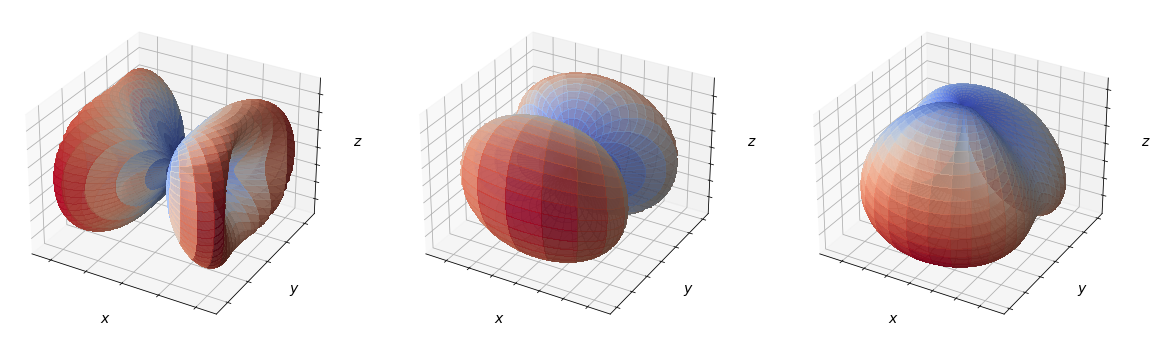

In [33]:
info_den = [S_xx_imp_num / ds_xx_imp, S_yy_imp_num / ds_yy_imp, S_zz_imp_num / ds_zz_imp]

# Number on the x-y-z scale doesn't have physical meaning!
cmap = plt.get_cmap('coolwarm')

fig = plt.figure(figsize=(20, 7))
for i, den in enumerate(info_den):
    norm = colors.Normalize(vmin=den.min(), vmax=den.max())
    
    # Project magnitude onto x, y, and z components, for plotting purpose
    xx = den * np.sin(tt) * np.cos(pp)
    yy = den * np.sin(tt) * np.sin(pp)
    zz = den * np.cos(tt)
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot = ax.plot_surface(
        xx, yy, zz, facecolors=cmap(norm(den)),
        linewidth=0, antialiased=False, alpha=0.8)

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_ylabel(r'$y$', fontsize=14)
    ax.set_zlabel(r'$z$', fontsize=14)
plt.show()

Now let's calculate the imprecision noise for a lens with some NA that collects the forward/backward scattered light.

In [98]:
def get_imprecision_forward(p_sca, na):
    thetamax = np.arcsin(na)
    theta = np.linspace(0, thetamax, 1000)
    phi = np.linspace(0, 2*pi, 1000)
    tt, pp = np.meshgrid(theta, phi)
        
    # Differential scattered power
    dp = (3/ (8*pi)) * p_sca * ( 1 - (np.sin(tt)**2) * (np.cos(pp)**2) ) * np.sin(tt)
    
    A = calc_geometric_factor(na)  # Geometrical factor for z
    ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
    ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
    ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)
    
    # Integrate over `theta` and `phi` within the collection area, then take inverse
    # for total noise
    # Note that these are double-sided spectra
    s_xx = 1 / ( np.trapz( np.trapz(1 / ds_xx_imp, phi, axis=1), theta) )
    s_yy = 1 / ( np.trapz( np.trapz(1 / ds_yy_imp, phi, axis=1), theta) )
    s_zz = 1 / ( np.trapz( np.trapz(1 / ds_zz_imp, phi, axis=1), theta) )
    
    return np.asarray([s_xx, s_yy, s_zz])

In [99]:
def get_imprecision_backward(p_sca, na):
    thetamax = np.arcsin(na)
    theta = np.linspace(pi-thetamax, pi, 1000)  # Backward scattered
    phi = np.linspace(0, 2*pi, 1000)
    tt, pp = np.meshgrid(theta, phi)
        
    # Differential scattered power
    dp = (3/ (8*pi)) * p_sca * ( 1 - (np.sin(tt)**2) * (np.cos(pp)**2) ) * np.sin(tt)
    
    A = calc_geometric_factor(na)  # Geometrical factor for z
    ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
    ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
    ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)
    
    # Integrate over `theta` and `phi` within the collection area, then take inverse
    # for total noise
    # Note that these are double-sided spectra
    s_xx = 1 / ( np.trapz( np.trapz(1 / ds_xx_imp, phi, axis=1), theta) )
    s_yy = 1 / ( np.trapz( np.trapz(1 / ds_yy_imp, phi, axis=1), theta) )
    s_zz = 1 / ( np.trapz( np.trapz(1 / ds_zz_imp, phi, axis=1), theta) )
    
    return np.asarray([s_xx, s_yy, s_zz])

In [100]:
print(f'Imprecision noise, perfect collection (double sided, x-y-z): {S_xx_imp_num:.3e}, {S_yy_imp_num:.3e}, {S_zz_imp_num:.3e}')

Imprecision noise, perfect collection (double sided, x-y-z): 1.897e-27, 9.483e-28, 3.299e-28


Because the information density for $x$ and $y$ are symmetric in $z$ we should get the same answer. With a NA=0.77 lens the imprecision noise spectrum is about 10 times larger, so $\eta_d \approx 0.1$.

Also our calculation confirms that backscatter detection performs orders of magnitude better in $z$ than the forward one. 

In [101]:
xx, yy, zz = get_imprecision_forward(p_sca=p_sca, na=0.77)
print(f'Imprecision noise, forward NA=0.77 (double sided, x-y-z): {xx:.3e}, {yy:.3e}, {zz:.3e}')
print(f'Information collection efficiency: {S_xx_imp_num/xx:.3e}, {S_yy_imp_num/yy:.3e}, {S_zz_imp_num/zz:.3e}')

Imprecision noise, forward NA=0.77 (double sided, x-y-z): 1.269e-26, 9.784e-27, 1.529e-25
Information collection efficiency: 1.495e-01, 9.692e-02, 2.157e-03


C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)


In [102]:
xx, yy, zz = get_imprecision_backward(p_sca=p_sca, na=0.77)
print(f'Imprecision noise, backward NA=0.77 (double sided, x-y-z): {xx:.3e}, {yy:.3e}, {zz:.3e}')
print(f'Information collection efficiency: {S_xx_imp_num/xx:.3e}, {S_yy_imp_num/yy:.3e}, {S_zz_imp_num/zz:.3e}')

Imprecision noise, backward NA=0.77 (double sided, x-y-z): 1.269e-26, 9.784e-27, 5.997e-28
Information collection efficiency: 1.495e-01, 9.692e-02, 5.500e-01


C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3482035305.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )


Let's calculate the information collection efficiency as a function of NA.

In [103]:
nas = np.linspace(0.1, 0.99, 50)
imp_forward = np.empty((3, nas.size))
imp_backward = np.empty((3, nas.size))

for i, na in enumerate(nas):
    imp_forward[0][i], imp_forward[1][i], imp_forward[2][i] = get_imprecision_forward(p_sca=p_sca, na=na)
    imp_backward[0][i], imp_backward[1][i], imp_backward[2][i] = get_imprecision_backward(p_sca=p_sca, na=na)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ds_xx_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.cos(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ds_yy_imp = (hbar*c) / ( 4 * k * (np.sin(tt)**2) * (np.sin(pp)**2) * dp )
C:\Users\yuhan\AppData\Local\Temp\ipykernel_10352\3013248222.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ds_zz_imp = (hbar*c) / ( 4 * k * ((np.cos(tt) - A)**2) * dp)


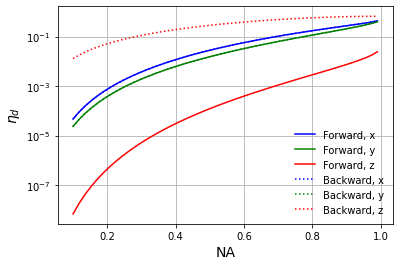

In [104]:
plt.plot(nas, S_xx_imp_num/imp_forward[0], 'b', label='Forward, x')
plt.plot(nas, S_yy_imp_num/imp_forward[1], 'g', label='Forward, y')
plt.plot(nas, S_zz_imp_num/imp_forward[2], 'r', label='Forward, z')
plt.plot(nas, S_xx_imp_num/imp_backward[0], 'b:', label='Backward, x')
plt.plot(nas, S_yy_imp_num/imp_backward[1], 'g:', label='Backward, y')
plt.plot(nas, S_zz_imp_num/imp_backward[2], 'r:', label='Backward, z')

plt.yscale('log')
plt.xlabel('NA', fontsize=14)
plt.ylabel('$\eta_d$', fontsize=14)
plt.grid()
plt.legend(frameon=False)

## Realistic momentum sensitivity

Calculate (or at least try to estimate) the sensitivity in a realistic setup. We assume the noise scales as
$$
    S^{\mathrm{imp}}_{yy}(\omega) \rightarrow S^{\mathrm{imp}}_{yy}(\omega) / \eta_d, \\
    S^{\mathrm{bac}}_{FF}(\omega) \rightarrow S^{\mathrm{bac}}_{FF}(\omega) / \eta_e,
$$
where $\eta_d$ and $\eta_d$ represent information losses due to detection and environmental interaction (gas collisions, feedback noise, etc., which are approximately random forces), respectively.

In [60]:
def calc_geometric_factor(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    return D / C

In [52]:
def full_momentum_sensitivity(p_sca, gamma, eta_d, eta_e, axis='y', omega_0=Omega_0, na=0.77):
    omega = np.linspace(0, 2*300e3*np.pi, 10000)
    
    zpf = np.sqrt(hbar / (2 * m * omega_0)) # Zero point fluctuation (m)
    chi = (1 / m) / (omega_0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility
    
    if axis == 'y':
        S_imp  = (1/eta_d) * (5/2) * (hbar * c / (4 * k)) / p_sca
        S_ff_ba = (1/eta_e) * (2/5) * (hbar * k / c) * p_sca       # Backaction force spectrum
    elif axis == 'x':
        S_imp  = (1/eta_d) * (5/1) * (hbar * c / (4 * k)) / p_sca
        S_ff_ba = (1/eta_e) * (1/5) * (hbar * k / c) * p_sca
    elif axis == 'z':
        A = calc_geometric_factor(na)
        S_imp  = (1/eta_d) * (1/(2/5 + A**2)) * (hbar * c / (4 * k)) / p_sca
        S_ff_ba = (1/eta_e) * (2/5 + A**2) * (hbar * k / c) * p_sca
    
    # One-sided spectra
    S_xyz_imp = 2 * S_imp
    S_f_xyz_ba = 2 * S_ff_ba
    S_xyz_zpf = zpf**2 * gamma / ( (omega-omega_0)**2 + (gamma/2)**2 )
    S_xyz_tot = np.full_like(omega, S_xyz_imp) + S_f_xyz_ba * np.abs(chi) * np.abs(chi) + S_xyz_zpf
    
    integrand = (1 / (2*pi)) * np.abs(chi) * np.abs(chi) / S_xyz_tot
    delta_p = 0.5 * np.sqrt(1 / np.trapz(integrand, omega))
    
    return delta_p * SI2ev / 1000

This calculation assumes $y$-direction with 150 kHz resonant frequency.

In [117]:
eta_dd_xy = np.logspace(-4, 0, 2000)
delta_pp_y = np.empty((4, eta_dd_xy.size))
delta_pp_x = np.empty((4, eta_dd_xy.size))

for i, eta_d in enumerate(eta_dd_xy):
    delta_pp_y[0][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=1)
    delta_pp_y[1][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.1)
    delta_pp_y[2][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.01)
    delta_pp_y[3][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.001)

    
    delta_pp_x[0][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=1, axis='x')
    delta_pp_x[1][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.1, axis='x')
    delta_pp_x[2][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.01, axis='x')
    delta_pp_x[3][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.001, axis='x')

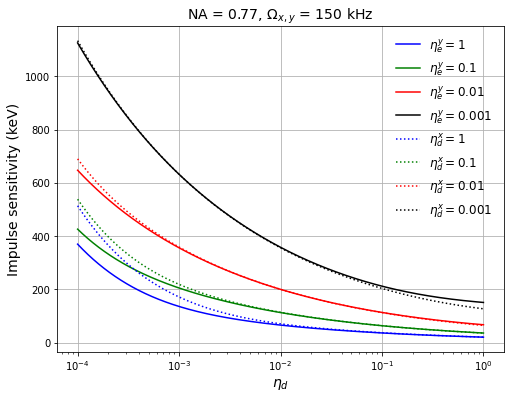

In [121]:
plt.figure(figsize=(8, 6))

plt.plot(eta_dd_xy, delta_pp_y[0], color='b', label=r'$\eta^y_e = 1$')
plt.plot(eta_dd_xy, delta_pp_y[1], color='g', label=r'$\eta^y_e = 0.1$')
plt.plot(eta_dd_xy, delta_pp_y[2], color='r', label=r'$\eta^y_e = 0.01$')
plt.plot(eta_dd_xy, delta_pp_y[3], color='k', label=r'$\eta^y_e = 0.001$')

plt.plot(eta_dd_xy, delta_pp_x[0], 'b:', label=r'$\eta^x_d = 1$')
plt.plot(eta_dd_xy, delta_pp_x[1], 'g:', label=r'$\eta^x_d = 0.1$')
plt.plot(eta_dd_xy, delta_pp_x[2], 'r:', label=r'$\eta^x_d = 0.01$')
plt.plot(eta_dd_xy, delta_pp_x[3], 'k:', label=r'$\eta^x_d = 0.001$')

plt.xlabel(r'$\eta_d$', fontsize=14)
plt.ylabel(r'Impulse sensitivity (keV)', fontsize=14)
plt.title(r'NA = 0.77, $\Omega_{x, y}$ = 150 kHz', fontsize=14)
plt.legend(frameon=False, fontsize=12)
plt.grid()
plt.xscale('log')

In [119]:
eta_dd = np.logspace(-3, 0, 1000)
delta_pp_z = np.empty((4, eta_dd.size))
omega_z = 2 * pi * 30 * 1000

for i, eta_d in enumerate(eta_dd):
    delta_pp_z[0][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=1, axis='z', omega_0=omega_z, na=0.77)
    delta_pp_z[1][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.1, axis='z', omega_0=omega_z, na=0.77)
    delta_pp_z[2][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.01, axis='z', omega_0=omega_z, na=0.77)
    delta_pp_z[3][i] = full_momentum_sensitivity(p_sca, gamma, eta_d=eta_d, eta_e=0.001, axis='z', omega_0=omega_z, na=0.77)

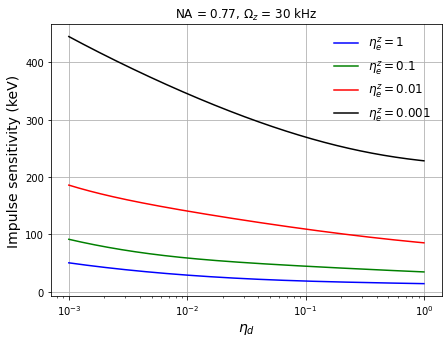

In [123]:
plt.figure(figsize=(7, 5))

plt.plot(eta_dd, delta_pp_z[0], color='b', label=r'$\eta^z_e = 1$')
plt.plot(eta_dd, delta_pp_z[1], color='g', label=r'$\eta^z_e = 0.1$')
plt.plot(eta_dd, delta_pp_z[2], color='r', label=r'$\eta^z_e = 0.01$')
plt.plot(eta_dd, delta_pp_z[3], color='k', label=r'$\eta^z_e = 0.001$')

plt.xlabel(r'$\eta_d$', fontsize=14)
plt.ylabel(r'Impulse sensitivity (keV)', fontsize=14)
plt.title(fr'NA = 0.77, $\Omega_z$ = 30 kHz')
plt.legend(frameon=False, fontsize=12)
plt.grid()
plt.xscale('log')